In [2]:
import tensorflow as tf
import numpy as np
import cv2
import os
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd  # Import pandas for DataFrame operations
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest, mutual_info_classif
from sklearn.linear_model import LogisticRegression

# Try importing UMAP and handle gracefully if unavailable
try:
    from umap import UMAP
    UMAP_AVAILABLE = True
except ModuleNotFoundError:
    UMAP_AVAILABLE = False
    print("UMAP is not installed. Please install it using 'pip install umap-learn' if required.")

# Load dataset
Datadirectory = "/Users/svdix/Desktop/face_mask"
Classes = ["mask", "without_mask"]
training_Data = []

# Helper function to create training data
def create_training_Data():
    for category in Classes:
        path = os.path.join(Datadirectory, category)
        class_num = Classes.index(category)
        for img in os.listdir(path):
            try:
                img_array = cv2.imread(os.path.join(path, img), cv2.IMREAD_GRAYSCALE)
                new_array = cv2.resize(img_array, (100, 100))
                training_Data.append([new_array, class_num])
            except Exception as e:
                pass

create_training_Data()

# Preprocessing
X = []
y = []
for features, label in training_Data:
    X.append(features)
    y.append(label)
X = np.array(X).reshape(-1, 10000)  # Flatten images
X = StandardScaler().fit_transform(X)  # Standardize features
y = np.array(y)




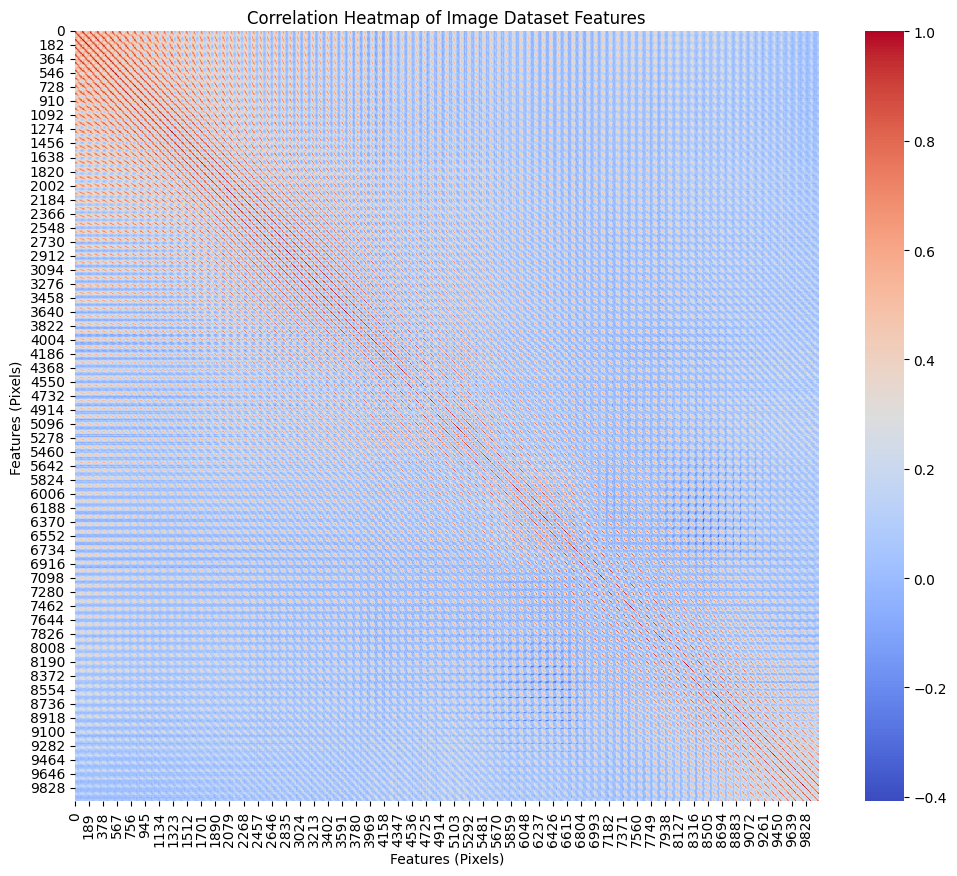

In [3]:

# Assuming the dataset directory and classes are already defined
Datadirectory = "/Users/svdix/Desktop/face_mask"
Classes = ["mask", "without_mask"]

# Helper function to load images and flatten them
def load_images_and_flatten(datadirectory, classes, img_size=(100, 100)):
    data = []
    for category in classes:
        path = os.path.join(datadirectory, category)
        for img in os.listdir(path):
            try:
                # Read image in grayscale
                img_array = cv2.imread(os.path.join(path, img), cv2.IMREAD_GRAYSCALE)
                # Resize and flatten the image
                img_resized = cv2.resize(img_array, img_size).flatten()
                data.append(img_resized)
            except Exception as e:
                pass
    return np.array(data)

# Load the dataset images
X_images = load_images_and_flatten(Datadirectory, Classes)

# Standardize the dataset (important for correlation calculation)
X_standardized = (X_images - X_images.mean(axis=0)) / X_images.std(axis=0)

# Calculate the correlation matrix
correlation_matrix = np.corrcoef(X_standardized.T)

# Plot the correlation heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, cmap="coolwarm", cbar=True)
plt.title("Correlation Heatmap of Image Dataset Features")
plt.xlabel("Features (Pixels)")
plt.ylabel("Features (Pixels)")
plt.show()


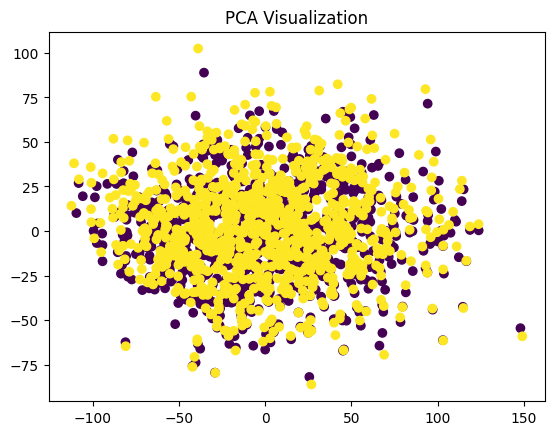

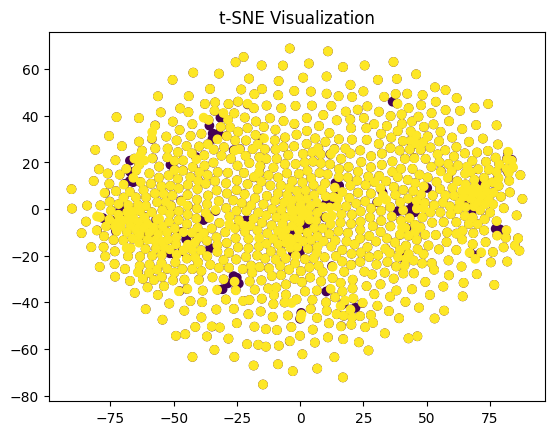

U:\Anaconda\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


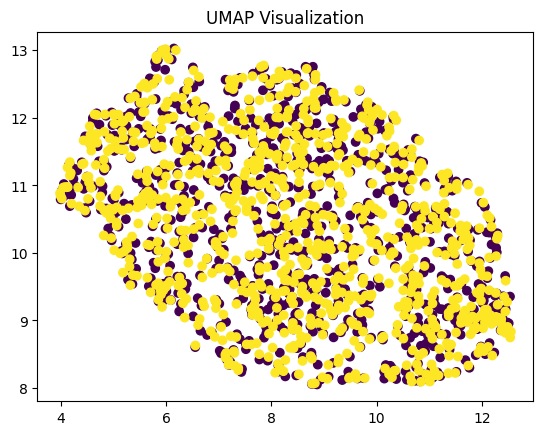

In [4]:

# Create a DataFrame for better visualization
X_df = pd.DataFrame(X, columns=[f"Feature_{i}" for i in range(X.shape[1])])
y_df = pd.Series(y, name="Target")

# Combine features and target into a single DataFrame
data_df = pd.concat([X_df, y_df], axis=1)


# 2. Visualization strategies: PCA, t-SNE, UMAP
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y, cmap='viridis')
plt.title('PCA Visualization')
plt.show()

tsne = TSNE(n_components=2, perplexity=30, random_state=42)
X_tsne = tsne.fit_transform(X)
plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=y, cmap='viridis')
plt.title('t-SNE Visualization')
plt.show()

if UMAP_AVAILABLE:
    umap = UMAP(n_components=2, random_state=42)
    X_umap = umap.fit_transform(X)
    plt.scatter(X_umap[:, 0], X_umap[:, 1], c=y, cmap='viridis')
    plt.title('UMAP Visualization')
    plt.show()


In [5]:
# Train and evaluate model function
def train_and_evaluate_model(X_train, X_val, y_train, y_val, save_path="mask_model.h5", metadata_path="model_metadata.pkl"):
    model = tf.keras.Sequential([
        tf.keras.layers.Dense(128, activation='relu', input_shape=(X_train.shape[1],)),
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

    history = model.fit(
        X_train, y_train, validation_data=(X_val, y_val),
        epochs=50, batch_size=32, callbacks=[early_stopping], verbose=1
    )

    # Save the trained model in .h5 format
    model.save(save_path)
    print(f"Model saved to {save_path}")

    # Save metadata using pickle
    metadata = {
        "model_path": save_path,
        "input_shape": model.input_shape,
        "output_classes": 2,
        "training_history": history.history
    }

    with open(metadata_path, "wb") as f:
        pickle.dump(metadata, f)
    print(f"Metadata saved to {metadata_path}")

    return model, history

In [6]:
# Define cross-validation strategy
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

U:\Anaconda\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - accuracy: 0.7285 - loss: 0.7602 - val_accuracy: 0.8617 - val_loss: 0.4851
Epoch 2/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.8916 - loss: 0.3671 - val_accuracy: 0.8617 - val_loss: 0.5599
Epoch 3/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.8997 - loss: 0.4278 - val_accuracy: 0.9016 - val_loss: 0.3071
Epoch 4/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.9110 - loss: 0.3203 - val_accuracy: 0.9229 - val_loss: 0.3511
Epoch 5/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.9325 - loss: 0.3164 - val_accuracy: 0.9149 - val_loss: 0.3818
Epoch 6/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.9443 - loss: 0.1864 - val_accuracy: 0.9016 - val_loss: 0.3839
Epoch 7/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.9369 - loss: 0.1818 - val_accuracy: 0.9016 - val_loss: 0.4424
Epoch 8/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.9462 - loss: 0.1808 - val_accuracy: 0.9202 - v

Model saved to mask_model.h5
Metadata saved to model_metadata.pkl
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
              precision    recall  f1-score   support

           0       0.88      0.97      0.92       190
           1       0.96      0.87      0.92       186

    accuracy                           0.92       376
   macro avg       0.92      0.92      0.92       376
weighted avg       0.92      0.92      0.92       376

[[184   6]
 [ 24 162]]
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


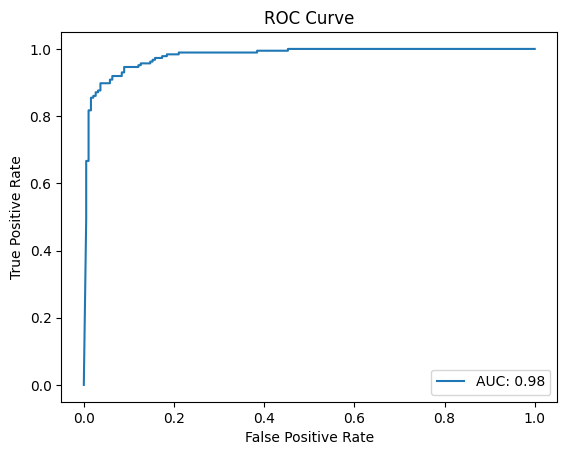

Epoch 1/50


U:\Anaconda\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


47/47 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 0.7408 - loss: 0.9380 - val_accuracy: 0.8511 - val_loss: 0.5372
Epoch 2/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.8958 - loss: 0.4034 - val_accuracy: 0.8989 - val_loss: 0.4840
Epoch 3/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.9093 - loss: 0.3353 - val_accuracy: 0.8936 - val_loss: 0.5691
Epoch 4/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.9275 - loss: 0.2692 - val_accuracy: 0.9043 - val_loss: 0.5554
Epoch 5/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.9265 - loss: 0.3473 - val_accuracy: 0.9176 - val_loss: 0.4547
Epoch 6/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.9333 - loss: 0.2462 - val_accuracy: 0.8936 - val_loss: 0.4420
Epoch 7/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.9506 - loss: 0.2281 - val_accuracy: 0.9069 - val_loss: 0.5431
Epoch 8/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.9482 - loss: 0.1788 - val_accuracy: 0.9255 - val_loss: 0.

Model saved to mask_model.h5
Metadata saved to model_metadata.pkl
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
              precision    recall  f1-score   support

           0       0.89      0.95      0.92       190
           1       0.95      0.88      0.91       186

    accuracy                           0.92       376
   macro avg       0.92      0.92      0.92       376
weighted avg       0.92      0.92      0.92       376

[[181   9]
 [ 22 164]]
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


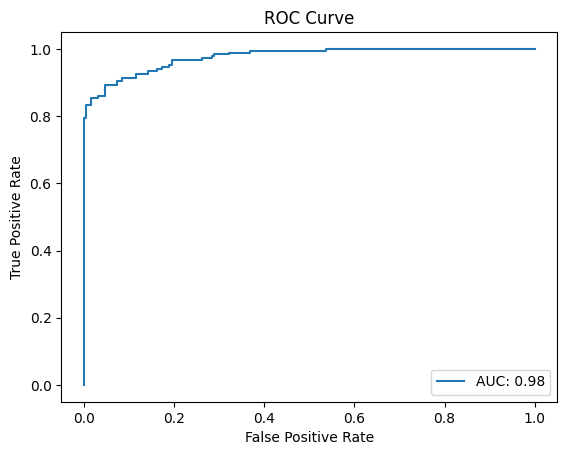

Epoch 1/50


U:\Anaconda\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


47/47 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 0.7452 - loss: 1.0563 - val_accuracy: 0.8511 - val_loss: 0.9007
Epoch 2/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.8713 - loss: 0.5822 - val_accuracy: 0.8777 - val_loss: 0.3541
Epoch 3/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.9114 - loss: 0.2820 - val_accuracy: 0.8856 - val_loss: 0.3816
Epoch 4/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.9273 - loss: 0.2530 - val_accuracy: 0.9016 - val_loss: 0.4053
Epoch 5/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.9336 - loss: 0.3029 - val_accuracy: 0.8989 - val_loss: 0.4618
Epoch 6/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.9440 - loss: 0.2283 - val_accuracy: 0.9309 - val_loss: 0.2804
Epoch 7/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.9460 - loss: 0.2174 - val_accuracy: 0.9282 - val_loss: 0.3145
Epoch 8/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.9605 - loss: 0.1366 - val_accuracy: 0.9122 - val_loss: 0.

Model saved to mask_model.h5
Metadata saved to model_metadata.pkl
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
              precision    recall  f1-score   support

           0       0.88      0.96      0.92       190
           1       0.96      0.87      0.91       186

    accuracy                           0.91       376
   macro avg       0.92      0.91      0.91       376
weighted avg       0.92      0.91      0.91       376

[[183   7]
 [ 25 161]]
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


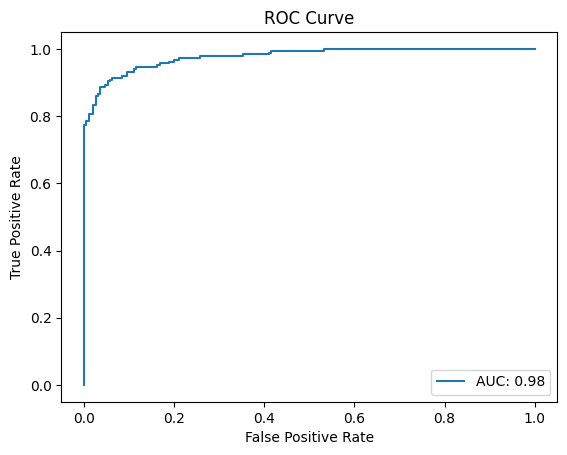

Epoch 1/50


U:\Anaconda\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


47/47 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 0.7276 - loss: 1.1755 - val_accuracy: 0.8987 - val_loss: 0.4457
Epoch 2/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.9002 - loss: 0.4667 - val_accuracy: 0.8907 - val_loss: 0.4475
Epoch 3/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.9217 - loss: 0.3518 - val_accuracy: 0.8880 - val_loss: 0.5749
Epoch 4/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.9219 - loss: 0.3096 - val_accuracy: 0.9120 - val_loss: 0.5818
Epoch 5/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.9192 - loss: 0.3504 - val_accuracy: 0.9013 - val_loss: 0.5773
Epoch 6/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.9500 - loss: 0.2776 - val_accuracy: 0.9227 - val_loss: 0.6026


Model saved to mask_model.h5
Metadata saved to model_metadata.pkl
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
              precision    recall  f1-score   support

           0       0.91      0.94      0.92       190
           1       0.93      0.91      0.92       185

    accuracy                           0.92       375
   macro avg       0.92      0.92      0.92       375
weighted avg       0.92      0.92      0.92       375

[[178  12]
 [ 17 168]]
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


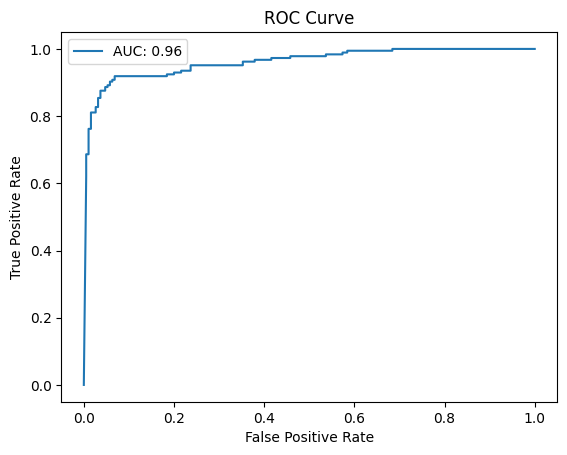

Epoch 1/50


U:\Anaconda\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


47/47 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 0.7851 - loss: 0.7781 - val_accuracy: 0.8907 - val_loss: 0.5762
Epoch 2/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.8689 - loss: 0.5736 - val_accuracy: 0.8853 - val_loss: 0.4632
Epoch 3/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.9104 - loss: 0.3295 - val_accuracy: 0.8773 - val_loss: 0.5622
Epoch 4/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.9176 - loss: 0.3170 - val_accuracy: 0.9120 - val_loss: 0.3405
Epoch 5/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.9358 - loss: 0.2443 - val_accuracy: 0.9227 - val_loss: 0.3580
Epoch 6/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.9432 - loss: 0.2598 - val_accuracy: 0.9253 - val_loss: 0.4057
Epoch 7/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.9507 - loss: 0.1776 - val_accuracy: 0.9120 - val_loss: 0.5350
Epoch 8/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.9589 - loss: 0.2208 - val_accuracy: 0.9280 - val_loss: 0.

Model saved to mask_model.h5
Metadata saved to model_metadata.pkl
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
              precision    recall  f1-score   support

           0       0.95      0.91      0.93       190
           1       0.91      0.95      0.93       185

    accuracy                           0.93       375
   macro avg       0.93      0.93      0.93       375
weighted avg       0.93      0.93      0.93       375

[[173  17]
 [ 10 175]]
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


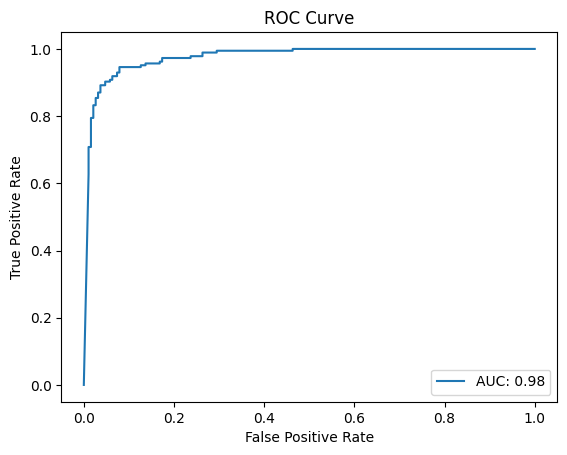

In [7]:
# Perform cross-validation and train the model
for train_index, val_index in skf.split(X, y):
    X_train, X_val = X[train_index], X[val_index]
    y_train, y_val = y[train_index], y[val_index]
    model, history = train_and_evaluate_model(X_train, X_val, y_train, y_val)

    y_pred = (model.predict(X_val) > 0.5).astype(int)
    print(classification_report(y_val, y_pred))
    print(confusion_matrix(y_val, y_pred))

    # ROC-AUC and Curve
    y_pred_prob = model.predict(X_val).ravel()
    fpr, tpr, _ = roc_curve(y_val, y_pred_prob)
    auc = roc_auc_score(y_val, y_pred_prob)
    plt.plot(fpr, tpr, label=f'AUC: {auc:.2f}')
    plt.title("ROC Curve")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.legend()
    plt.show()

Original feature size: 10000, Reduced feature size: 500


U:\Anaconda\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - accuracy: 0.8444 - loss: 0.3835 - val_accuracy: 0.9654 - val_loss: 0.1117
Epoch 2/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9674 - loss: 0.0903 - val_accuracy: 0.9601 - val_loss: 0.1034
Epoch 3/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9792 - loss: 0.0617 - val_accuracy: 0.9681 - val_loss: 0.0872
Epoch 4/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9885 - loss: 0.0449 - val_accuracy: 0.9734 - val_loss: 0.0932
Epoch 5/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9902 - loss: 0.0341 - val_accuracy: 0.9628 - val_loss: 0.1103
Epoch 6/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9898 - loss: 0.0309 - val_accuracy: 0.9681 - val_loss: 0.1023
Epoch 7/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9920 - loss: 0.0204 - val_accuracy: 0.9787 - val_loss: 0.0986
Epoch 8/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.9921 - loss: 0.0234 - val_accuracy: 0.9681 - val_los

Model saved to mask_model_selected.h5
Metadata saved to model_metadata_selected.pkl
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
              precision    recall  f1-score   support

           0       0.96      0.97      0.97       190
           1       0.97      0.96      0.97       186

    accuracy                           0.97       376
   macro avg       0.97      0.97      0.97       376
weighted avg       0.97      0.97      0.97       376

[[185   5]
 [  7 179]]
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 


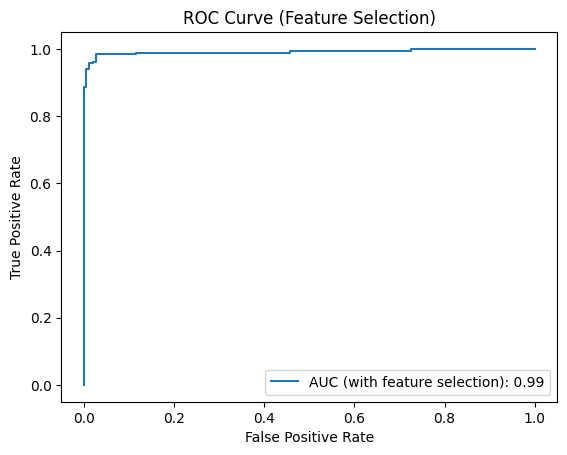

U:\Anaconda\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 4s 21ms/step - accuracy: 0.8394 - loss: 0.3874 - val_accuracy: 0.9335 - val_loss: 0.1437
Epoch 2/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.9576 - loss: 0.1162 - val_accuracy: 0.9628 - val_loss: 0.1004
Epoch 3/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9741 - loss: 0.0883 - val_accuracy: 0.9601 - val_loss: 0.0829
Epoch 4/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9830 - loss: 0.0444 - val_accuracy: 0.9734 - val_loss: 0.0640
Epoch 5/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9908 - loss: 0.0398 - val_accuracy: 0.9840 - val_loss: 0.0521
Epoch 6/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9886 - loss: 0.0358 - val_accuracy: 0.9840 - val_loss: 0.0390
Epoch 7/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9965 - loss: 0.0214 - val_accuracy: 0.9840 - val_loss: 0.0449
Epoch 8/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9958 - loss: 0.0213 - val_accuracy: 0.9814 - val_los

Model saved to mask_model_selected.h5
Metadata saved to model_metadata_selected.pkl
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step
              precision    recall  f1-score   support

           0       0.98      0.99      0.98       190
           1       0.99      0.98      0.98       186

    accuracy                           0.98       376
   macro avg       0.98      0.98      0.98       376
weighted avg       0.98      0.98      0.98       376

[[188   2]
 [  4 182]]
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 


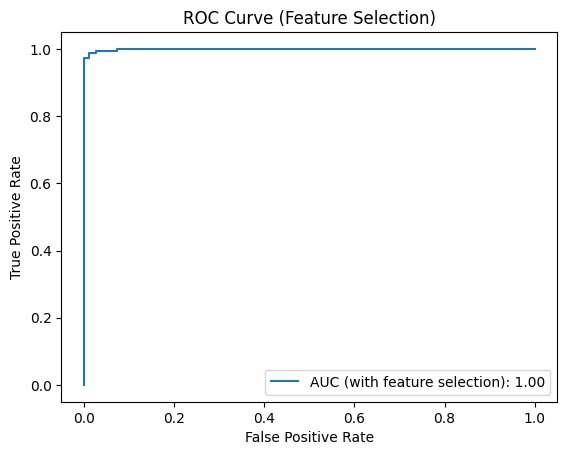

Epoch 1/50


U:\Anaconda\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


47/47 ━━━━━━━━━━━━━━━━━━━━ 4s 20ms/step - accuracy: 0.8209 - loss: 0.3446 - val_accuracy: 0.9441 - val_loss: 0.1013
Epoch 2/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.9704 - loss: 0.0991 - val_accuracy: 0.9548 - val_loss: 0.1034
Epoch 3/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.9816 - loss: 0.0619 - val_accuracy: 0.9601 - val_loss: 0.0955
Epoch 4/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9877 - loss: 0.0510 - val_accuracy: 0.9654 - val_loss: 0.0918
Epoch 5/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9941 - loss: 0.0249 - val_accuracy: 0.9681 - val_loss: 0.0945
Epoch 6/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9962 - loss: 0.0214 - val_accuracy: 0.9601 - val_loss: 0.1075
Epoch 7/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9981 - loss: 0.0124 - val_accuracy: 0.9654 - val_loss: 0.1151
Epoch 8/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.9960 - loss: 0.0134 - val_accuracy: 0.9654 - val_loss: 0.1098

Model saved to mask_model_selected.h5
Metadata saved to model_metadata_selected.pkl
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
              precision    recall  f1-score   support

           0       0.97      0.98      0.97       190
           1       0.98      0.97      0.97       186

    accuracy                           0.97       376
   macro avg       0.97      0.97      0.97       376
weighted avg       0.97      0.97      0.97       376

[[186   4]
 [  6 180]]
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


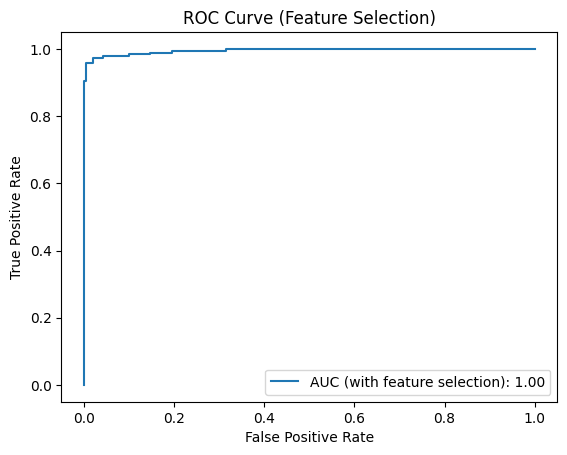

Epoch 1/50


U:\Anaconda\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8581 - loss: 0.2956 - val_accuracy: 0.9627 - val_loss: 0.1333
Epoch 2/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9696 - loss: 0.0863 - val_accuracy: 0.9600 - val_loss: 0.1203
Epoch 3/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9775 - loss: 0.0615 - val_accuracy: 0.9680 - val_loss: 0.1203
Epoch 4/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9847 - loss: 0.0517 - val_accuracy: 0.9707 - val_loss: 0.0992
Epoch 5/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9922 - loss: 0.0286 - val_accuracy: 0.9760 - val_loss: 0.0982
Epoch 6/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9893 - loss: 0.0256 - val_accuracy: 0.9680 - val_loss: 0.1106
Epoch 7/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9970 - loss: 0.0162 - val_accuracy: 0.9680 - val_loss: 0.1166
Epoch 8/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9964 - loss: 0.0145 - val_accuracy: 0.9653 - val_loss: 0.1363
Epo

Model saved to mask_model_selected.h5
Metadata saved to model_metadata_selected.pkl
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
              precision    recall  f1-score   support

           0       0.98      0.93      0.95       190
           1       0.93      0.98      0.96       185

    accuracy                           0.95       375
   macro avg       0.96      0.96      0.95       375
weighted avg       0.96      0.95      0.95       375

[[176  14]
 [  3 182]]
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


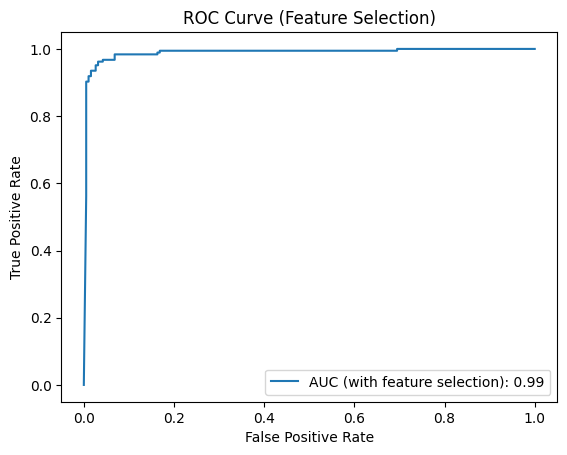

Epoch 1/50


U:\Anaconda\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.8952 - loss: 0.2817 - val_accuracy: 0.9520 - val_loss: 0.1431
Epoch 2/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9757 - loss: 0.0851 - val_accuracy: 0.9653 - val_loss: 0.0959
Epoch 3/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9773 - loss: 0.0636 - val_accuracy: 0.9573 - val_loss: 0.1024
Epoch 4/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9792 - loss: 0.0701 - val_accuracy: 0.9707 - val_loss: 0.1010
Epoch 5/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9886 - loss: 0.0389 - val_accuracy: 0.9707 - val_loss: 0.0862
Epoch 6/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9901 - loss: 0.0248 - val_accuracy: 0.9653 - val_loss: 0.1271
Epoch 7/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9935 - loss: 0.0247 - val_accuracy: 0.9733 - val_loss: 0.1045
Epoch 8/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9990 - loss: 0.0143 - val_accuracy: 0.9707 - val_loss: 0.1238
Epo

Model saved to mask_model_selected.h5
Metadata saved to model_metadata_selected.pkl
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
              precision    recall  f1-score   support

           0       0.96      0.98      0.97       190
           1       0.98      0.96      0.97       185

    accuracy                           0.97       375
   macro avg       0.97      0.97      0.97       375
weighted avg       0.97      0.97      0.97       375

[[187   3]
 [  7 178]]
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


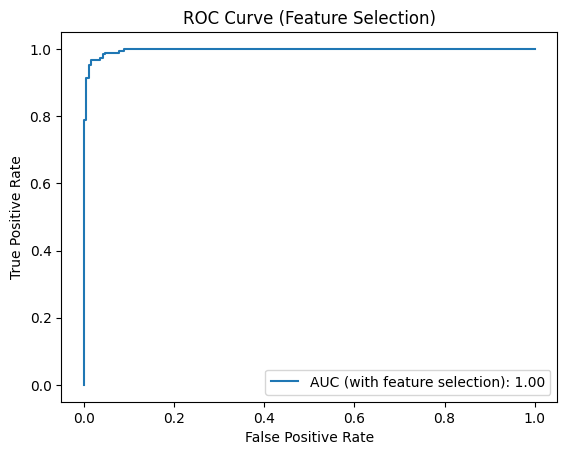

In [8]:
# Feature Selection using SelectKBest
k_best_features = 500  # You can adjust this number based on experimentation
selector = SelectKBest(score_func=mutual_info_classif, k=k_best_features)
X_selected = selector.fit_transform(X, y)

print(f"Original feature size: {X.shape[1]}, Reduced feature size: {X_selected.shape[1]}")

# Train and evaluate the model with selected features
for train_index, val_index in skf.split(X_selected, y):
    X_train, X_val = X_selected[train_index], X_selected[val_index]
    y_train, y_val = y[train_index], y[val_index]
    model, history = train_and_evaluate_model(X_train, X_val, y_train, y_val, save_path="mask_model_selected.h5", metadata_path="model_metadata_selected.pkl")

    y_pred = (model.predict(X_val) > 0.5).astype(int)
    print(classification_report(y_val, y_pred))
    print(confusion_matrix(y_val, y_pred))

    y_pred_prob = model.predict(X_val).ravel()
    fpr, tpr, _ = roc_curve(y_val, y_pred_prob)
    auc = roc_auc_score(y_val, y_pred_prob)
    plt.plot(fpr, tpr, label=f'AUC (with feature selection): {auc:.2f}')
    plt.title("ROC Curve (Feature Selection)")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.legend()
    plt.show()